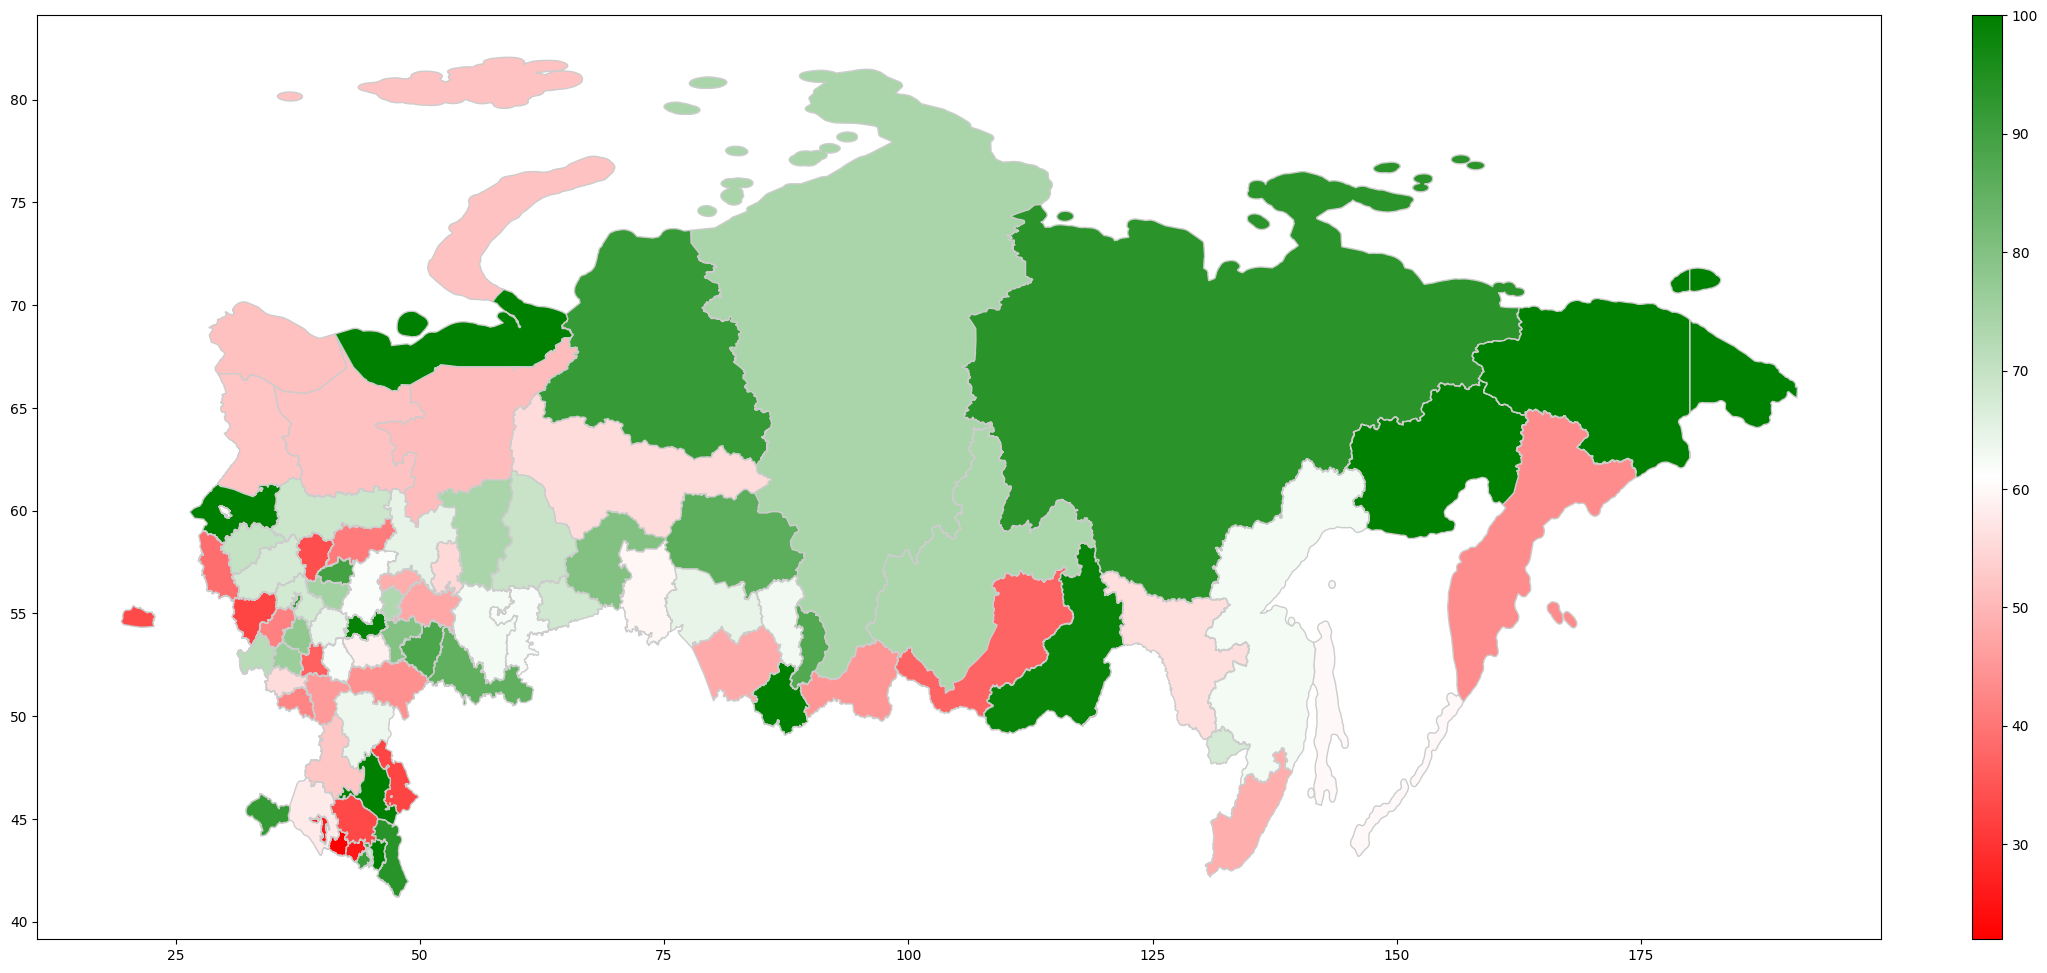

In [2]:
import difflib

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from fastapi import FastAPI, Response
from geopandas import GeoDataFrame
from shapely import MultiPolygon, Polygon
from shapely.affinity import translate
from shapely.geometry import LineString
from shapely.ops import split

app = FastAPI()


def translate_geometry(polygon: Polygon, geometry_list: list[Polygon | MultiPolygon], shift: int) -> None:
    """Translates polygon with shift and appends to geometry list.

    :param polygon:
    :param geometry_list:
    :param shift:
    """
    min_x, *_ = polygon.bounds
    if min_x >= shift:
        geometry_list.append(translate(polygon, xoff=-180 - shift))
    else:
        geometry_list.append(translate(polygon, xoff=180 - shift))


def shift_map(geo_dataframe: GeoDataFrame, shift: int) -> list[Polygon | MultiPolygon]:
    """

    :param geo_dataframe:
    :param shift:
    :return:
    """
    shift -= 180
    moved_map: list[Polygon | MultiPolygon] = []
    border = LineString([(shift, 90), (shift, -90)])

    split_map = [split(row, border) for row in geo_dataframe["geometry"]]

    for element in split_map:
        items = list(element.geoms)
        if len(items) == 1:
            translate_geometry(next(iter(items)), moved_map, shift)
            continue

        multipolygon: list[MultiPolygon] = []

        for item in items:
            translate_geometry(item, multipolygon, shift)

        moved_map.append(MultiPolygon(multipolygon))

    return moved_map


def get_data_for_plot() -> pd.DataFrame:
    geo_df = gpd.read_file(r'RF/admin_4.shp')[["name_ru", "ref", "geometry"]]

    polygons = []
    for idx, polygon in enumerate(geo_df.loc[23]['geometry'].geoms):
        if idx not in {0, 2, 3}:
            polygons.append(polygon)
            continue
        polygons.append(translate(polygon, xoff=300 + 60))
        
    geo_df['geometry'][23] = MultiPolygon(polygons)

    colormap_data = pd.read_csv(r'RF/colormap.csv')
    colormap_data['Названия строк'] = colormap_data['Названия строк'].replace(
        {
            'Республика Тыва': 'Тыва',
            'Удмуртская Республика': 'Удмуртия',
            'Чеченская Республика': 'Чечня',
            'Чувашская Республика - Чувашия': "Чувашия",
            "Республика Бурятия": "Бурятия"
        }
    )

    colormap_data['Процент'] = colormap_data['Процент'].str.replace("%", '').str.replace(',', '.').astype(float)

    target_region_names: list[str] = list(geo_df['name_ru'])
    colormap_region_names: list[str] = list(colormap_data['Названия строк'])
    target_region_names.sort()
    colormap_region_names.sort()

    target_map = {
        target: next(iter(difflib.get_close_matches(target, colormap_region_names, cutoff=0.5)), None)
        for target in target_region_names
    }

    geo_df['name_ru'].replace(target_map, inplace=True)

    return pd.merge(left=geo_df, right=colormap_data, left_on='name_ru', right_on='Названия строк', how="right")

%matplotlib inline
df = get_data_for_plot()

target_colormap_column: str = 'Процент'
from  matplotlib.colors import LinearSegmentedColormap
color_map=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
plt.ion()
fig, ax = plt.subplots(1, figsize=(30, 12))

df.plot(column=target_colormap_column, ax=ax, edgecolor='0.8', linewidth=1, cmap=color_map)

# ax.annotate(
#     'Процент дел (?) по регионам Российской Федерации',
#     xy=(0.1, .08),
#     xycoords='figure fraction',
#     horizontalalignment='left',
#     verticalalignment='bottom',
#     fontsize=10,
# )

fig.colorbar(
    plt.cm.ScalarMappable(
        norm=plt.Normalize(
            vmin=df[target_colormap_column].min(),
            vmax=df[target_colormap_column].max(),
        ),
        cmap=color_map,
    ),
    cax=fig.add_axes([0.85, 0.11, 0.01, 0.77]),
)

In [3]:
import branca.colormap as cm
colormap = cm.LinearColormap(colors=['red','green'], index=[0,100],vmin=0,vmax=100)
df.dropna().explore(column='Процент', style_kwds=dict(color="black"), tooltip=['Процент', 'name_ru'], legend=True).save(r'F:\Programming\Julya\russia_heatmap\sample_output.html')

In [142]:
df

,name_ru,ref,geometry,Названия строк,Количество по полю убыток,Сумма по полю З_ОТ,Сумма по полю У_ОТ,Процент
0,Карачаево-Черкесская Республика,RU-KC,"POLYGON ((42.68040 43.71410, 42.67796 43.71069...",Карачаево-Черкесская Республика,10,1747206,1363339,21.97
1,Кабардино - Балкарская Республика,RU-KB,"POLYGON ((44.47537 43.58294, 44.44452 43.54272...",Кабардино - Балкарская Республика,11,2257260,1672609,25.90
2,Республика Адыгея,RU-AD,"POLYGON ((40.77672 44.46985, 40.77557 44.46870...",Республика Адыгея,9,1428702,1055555,26.12
3,Смоленская область,RU-SMO,"POLYGON ((35.39500 55.59408, 35.39059 55.59439...",Смоленская область,26,5349425,3617958,32.37
4,Астраханская область,RU-AST,"MULTIPOLYGON (((46.88446 45.52371, 46.87677 45...",Астраханская область,11,2030833,1372365,32.42
...,...,...,...,...,...,...,...,...
81,Магаданская область,RU-MAG,"POLYGON ((163.49569 64.35813, 163.48496 64.354...",Магаданская область,1,30400,0,100.00
82,Ненецкий автономный округ,RU-CHU,"MULTIPOLYGON (((180.06591 62.68055, 180.06573 ...",Ненецкий автономный округ,1,229111,0,100.00
83,Ненецкий автономный округ,RU-NEN,"MULTIPOLYGON (((59.58943 66.83430, 59.56196 66...",Ненецкий автономный округ,1,229111,0,100.00
84,Республика Алтай,RU-AL,"POLYGON ((89.86565 50.47205, 89.86491 50.46968...",Республика Алтай,1,"288313,3",0,100.00
